In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
# from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.1


In [3]:
# Training settings
batch_size = 64
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = 'cuda'

In [6]:
os.makedirs('data', exist_ok=True)

In [7]:
train_dir = 'data/train'
# test_dir = 'data/test'

In [8]:
""" with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data') """

" with zipfile.ZipFile('train.zip') as train_zip:\n    train_zip.extractall('data')\n    \nwith zipfile.ZipFile('test.zip') as test_zip:\n    test_zip.extractall('data') "

In [9]:
train_list = glob.glob(os.path.join( 'data/train/daisy','*.jpg'))+glob.glob(os.path.join( 'data/train/dandelion','*.jpg'))+glob.glob(os.path.join( 'data/train/rose','*.jpg'))+glob.glob(os.path.join( 'data/train/sunflower','*.jpg'))+glob.glob(os.path.join( 'data/train/tulip','*.jpg'))
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [10]:
print(f"Train Data: {len(train_list)}")
# print(f"Test Data: {len(test_list)}")

Train Data: 4323


In [11]:
labels = [path.split('\\')[-2].split('/')[-1] for path in train_list]
print(labels[4000])

tulip


In [12]:
path = r"C:\Users\zhangmingyi\Desktop\flowerclass\data\train\tulip\112428665_d8f3632f36_n.jpg"
print(path.split('\\')[-2])

tulip


[ 861 3773 3093  467 3445 3172 2920  131 1686]


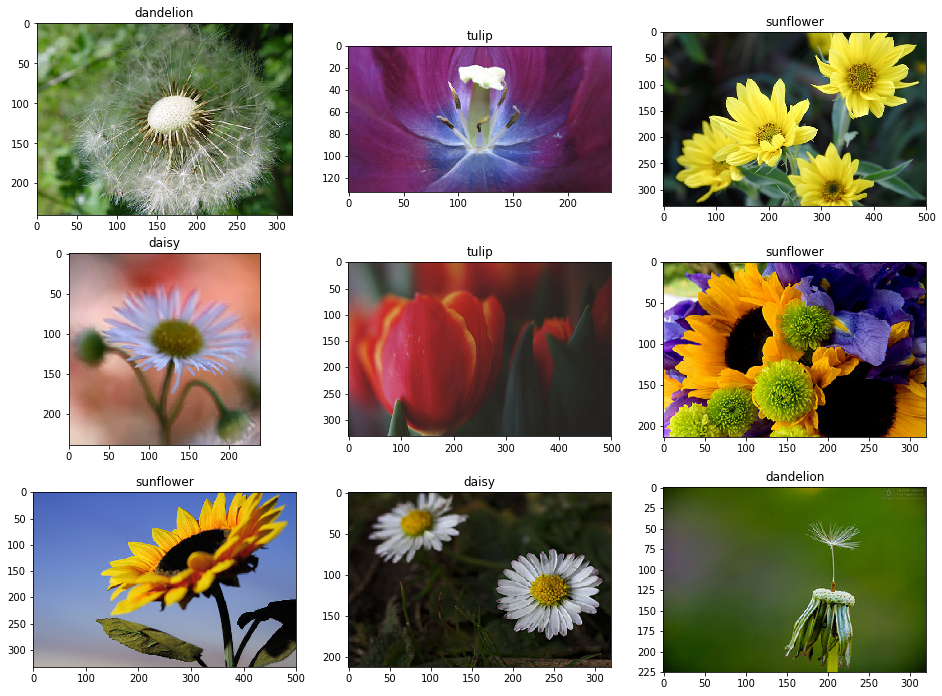

In [13]:

random_idx = np.random.randint(1, len(train_list), size=9)
print(random_idx.flatten())
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx,ax in enumerate(axes.ravel()):
    idx = random_idx.flatten()[idx]
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
# print(f"Test Data: {len(test_list)}")

Train Data: 3458
Validation Data: 865


In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


"""test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)"""

'test_transforms = transforms.Compose(\n    [\n        transforms.Resize((224, 224)),\n        transforms.RandomResizedCrop(224),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n    ]\n)'

In [17]:
class FlowerDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-2].split('/')[-1]
        if(label=="daisy"):
            label = 0
        elif(label=="dandelion"):
            label = 1
        elif(label=="rose"):
            label = 2
        elif(label=="sunflower"):
            label = 3
        elif(label=="tulip"):
            label = 4

        return img_transformed, label

In [18]:
train_data = FlowerDataset(train_list, transform=train_transforms)
valid_data = FlowerDataset(valid_list, transform=val_transforms)
# test_data = FlowerDataset(test_list, transform=test_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))

3458 55


In [21]:
print(len(valid_data), len(valid_loader))

865 14


In [22]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [23]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=5,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

Epoch : 1 - loss : 1.6075 - acc: 0.2276 - val_loss : 1.5969 - val_acc: 0.2586

Epoch : 2 - loss : 1.5842 - acc: 0.2551 - val_loss : 1.5596 - val_acc: 0.2528

Epoch : 3 - loss : 1.4868 - acc: 0.3045 - val_loss : 1.4368 - val_acc: 0.3375

Epoch : 4 - loss : 1.3932 - acc: 0.3443 - val_loss : 1.3719 - val_acc: 0.3821

Epoch : 5 - loss : 1.3794 - acc: 0.3599 - val_loss : 1.3442 - val_acc: 0.3684

Epoch : 6 - loss : 1.3482 - acc: 0.3702 - val_loss : 1.3291 - val_acc: 0.3854

Epoch : 7 - loss : 1.3406 - acc: 0.3744 - val_loss : 1.3680 - val_acc: 0.3687

Epoch : 8 - loss : 1.3556 - acc: 0.3810 - val_loss : 1.3280 - val_acc: 0.3796

Epoch : 9 - loss : 1.3309 - acc: 0.3969 - val_loss : 1.3279 - val_acc: 0.4006

Epoch : 10 - loss : 1.3127 - acc: 0.4000 - val_loss : 1.2971 - val_acc: 0.3984



EinopsError:  Error while computing Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
 Expected 4 dimensions, got 3

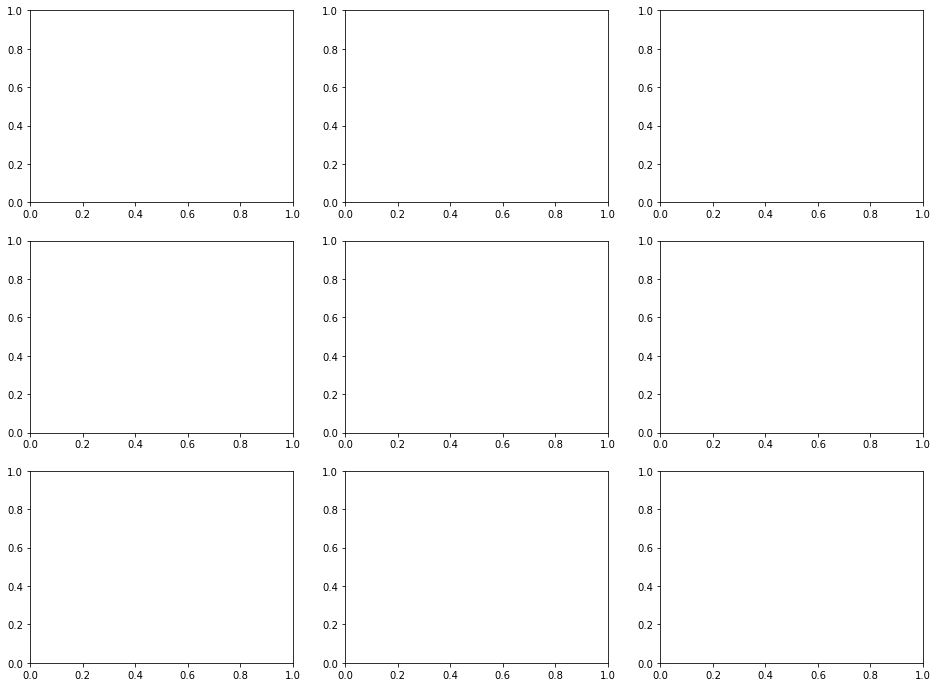

In [41]:
random_idx = np.random.randint(1, len(test_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx,ax in enumerate(axes.ravel()):
    idx = random_idx.flatten()[idx]
    img = Image.open(test_list[idx])
    data = test_transforms(img)
    output = model(data)
    ax.set_title(label)
    ax.imshow(img)
